# Continuous control using DDPG and prioritized experience replay


### 0. Import the necessary packages

In [1]:
from unityagents import UnityEnvironment
import numpy as np

import torch
import numpy as np
import pandas as pd
from collections import deque
import sys
import matplotlib.pyplot as plt
%matplotlib inline

# Import Agent
from Continuous_Control_agent import Agent 

### 1. Start the environment

If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).
**_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher_Linux/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Define training functions

In [5]:
#Define training function
def ddpg(agent, file_name_actor, file_name_critic, n_episodes=500, max_t=1000):
    """DDPG.
    
    Params
    =======================================================================================
        agent: agent class
        file_name: name of the file with the saved weights 
        n_episodes (int): maximum number of training episodes
     ======================================================================================   
    """
    print('Training started!!!!!!')
    scores = []                        # list containing scores from each episode    
    scores_window = deque(maxlen=100)  # last 100 scores
    previous_mean = -np.inf            # initialize mean over last 100 scores
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            reward = env_info.rewards 
            done = env_info.local_done 
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += np.mean(reward)
            #if done:
                #break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 20 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        
        #Saves weights with the best average score over 100 consecutive episodes
        if (np.mean(scores_window) >= previous_mean):
            previous_mean = np.mean(scores_window)
            torch.save(agent.actor_local.state_dict(), file_name_actor)
            torch.save(agent.critic_local.state_dict(), file_name_critic)
    return scores

In [6]:
#Define the function that shows training results
def show_results(scores):
    moving_average = pd.Series(scores).rolling(100).mean()
    episodes_greater_than_30 = np.where(moving_average>30)[0]  
    if episodes_greater_than_30.size > 0:
        end =episodes_greater_than_30[0]
        start = end - 100 + 1
        print('\nEnvironment solved in {:d} episodes!\tAverage score from episode {} to episode {}: {:.2f}'.\
              format(end+1, start+1, end+1, moving_average[end])) #Remember that episodes start from 1, not zero
    else:
        print('Neural net could not solve environment in {:d} episodes. Max average score was {:.2f}'.\
              format(len(scores), moving_average.max()))

    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores))+1, scores, label='Scores')
    plt.plot(np.arange(len(scores))+1, moving_average, label='Moving average 100 episodes')
    plt.title('Training evolution')
    plt.ylabel('Score and moving average 100 episodes')
    plt.xlabel('Episode #')
    plt.legend()
    plt.show()

### 4. Train the agent

Training started!!!!!!
Episode 20	Average Score: 0.42
Episode 40	Average Score: 0.73
Episode 60	Average Score: 1.04
Episode 80	Average Score: 1.51
Episode 100	Average Score: 2.29
Episode 120	Average Score: 3.73
Episode 140	Average Score: 5.72
Episode 160	Average Score: 8.18
Episode 180	Average Score: 10.88
Episode 200	Average Score: 13.63
Episode 220	Average Score: 16.60
Episode 240	Average Score: 19.47
Episode 260	Average Score: 22.12
Episode 280	Average Score: 24.37
Episode 300	Average Score: 26.10
Episode 320	Average Score: 27.34
Episode 340	Average Score: 28.47
Episode 360	Average Score: 29.64
Episode 380	Average Score: 30.99
Episode 400	Average Score: 32.07
Episode 420	Average Score: 31.99
Episode 440	Average Score: 31.21
Episode 460	Average Score: 29.83
Episode 480	Average Score: 27.00
Episode 500	Average Score: 23.38

Environment solved in 365 episodes!	Average score from episode 266 to episode 365: 30.03


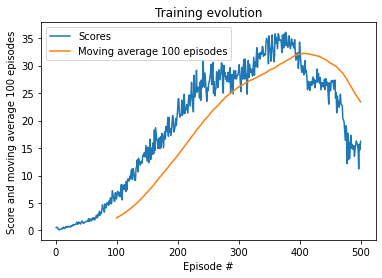

In [7]:
#Define the agent
agent = Agent(state_size, action_size, random_seed=1)

#Train the agent
scores = ddpg(agent, 'checkpoint_actor.pth', 'checkpoint_critic.pth')

#Show training results
show_results(scores)

### 5. Define the function that drives the behavior of the trained agent

In [17]:
#Define the function that shows trained model in action
def show_trained_agent(agent, file, n_episodes_trained=500, max_t=1000):
    agent.actor_local.load_state_dict(torch.load(file)) #load the weights from file
    scores_trained = []
    print('Observing performance of trained agent...')
    for i_episode in range(1, n_episodes_trained + 1):
        env_info = env.reset(train_mode=False)[brain_name]
        state = env_info.vector_observations
        score = 0
        for i in np.arange(max_t):
            action = agent.act(state=state, add_noise=False)
            env_info = env.step(action)[brain_name]
            state = env_info.vector_observations       # Update state
            reward = env_info.rewards                   # get the reward
            done = env_info.local_done                  # see if episode has finished
            score += np.mean(reward)                                # update the score  
        scores_trained.append(score)
        print('\rEpisode {:d}/{:d}\tScore: {:.2f}'.format(i_episode, n_episodes_trained, score), end="")
        if i_episode % 50 == 0:
            print('\rEpisode {:d}/{:d}\tScore: {:.2f}'.format(i_episode, n_episodes_trained, score))
    print('Average score over {:d} episodes: {:.2f}'.format(n_episodes_trained, np.mean(scores_trained)))
    return scores_trained

#Define the function that plots the scores of the trained agent
def show_results_trained(scores_trained):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores_trained))+1, scores_trained)
    plt.title('Trained agent scores')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show() 

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.hist(scores_trained)
    plt.title('Trained agent score distribution')
    plt.ylabel('Frequency')
    plt.xlabel('Score')
    plt.show()

### 6. Observe the behavior of the trained agent

Observing performance of trained agent...
Episode 50/500	Score: 36.82
Episode 100/500	Score: 36.53
Episode 150/500	Score: 36.33
Episode 200/500	Score: 35.76
Episode 250/500	Score: 35.11
Episode 300/500	Score: 34.74
Episode 350/500	Score: 36.95
Episode 400/500	Score: 36.17
Episode 450/500	Score: 36.29
Episode 500/500	Score: 34.87
Average score over 500 episodes: 35.58


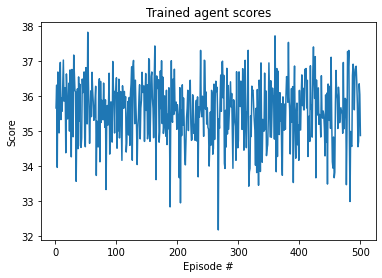

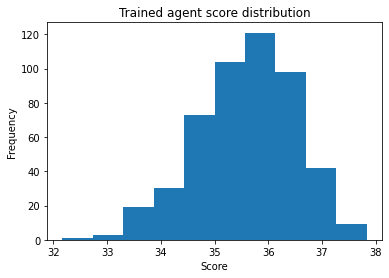

Score standard deviation: 0.91


In [18]:
#Run some episodes using the trained model
scores_trained = show_trained_agent(agent, 'checkpoint_actor.pth')

#Plot the scores of the trained agent
show_results_trained(scores_trained)

print('Score standard deviation: {:.2f}'.format(np.std(scores_trained)))

Close the environment when finished

In [19]:
env.close()